# Bio-indicators of climate

## Imports

In [1]:
from statistics import *
from visualization import *
from empirical_model import *
from linear_regression_model import *
from occupancy_detection_model import *
from scipy.special import expit

## Data generation for the 8 scenarios

In [2]:
# Covariables
n_train = 3000
cA_train = np.random.uniform(-np.sqrt(3), np.sqrt(3), n_train)
cB_train = np.random.uniform(-np.sqrt(3), np.sqrt(3), n_train)

# Probabilities of occupancy
psis = np.array([expit(1 + 3 * cA_train), expit(cA_train)])  # Steep, gentle
psis = np.tile(psis[:, np.newaxis, :], (1, 4, 1))

# Conditional probabilities of detection
ps = np.array([n_train * [0.5], expit(cA_train),
               expit(-cA_train), expit(cB_train)])  # Constant, positive, negative, independent
ps = np.tile(ps[np.newaxis, :, :], (2, 1, 1))

# Probabilities of detection, with 1 trial
ds = ps * psis

# Probabilities of detection with K trials
K = 2 # K trials per site
psk = 1 - (1 - ps) ** K
dsk = psk * psis

occupancy_labels = np.random.binomial(1, psis) # Binary draw for occupancy
number_detections_train = np.random.binomial(K, occupancy_labels * ds) # Binary draw for detection
binary_detections_train = 1 * (number_detections_train != 0)

labels = np.array([["Steep, constant", "Steep, positive", "Steep, negative", "Steep, independent"], 
                   ["Gentle, constant", "Gentle, positive", "Gentle, negative", "Gentle, independent"]])

## Plotting the 8 scenarios

2 occupancy-environment relationships and 4 detection-environment relationships.

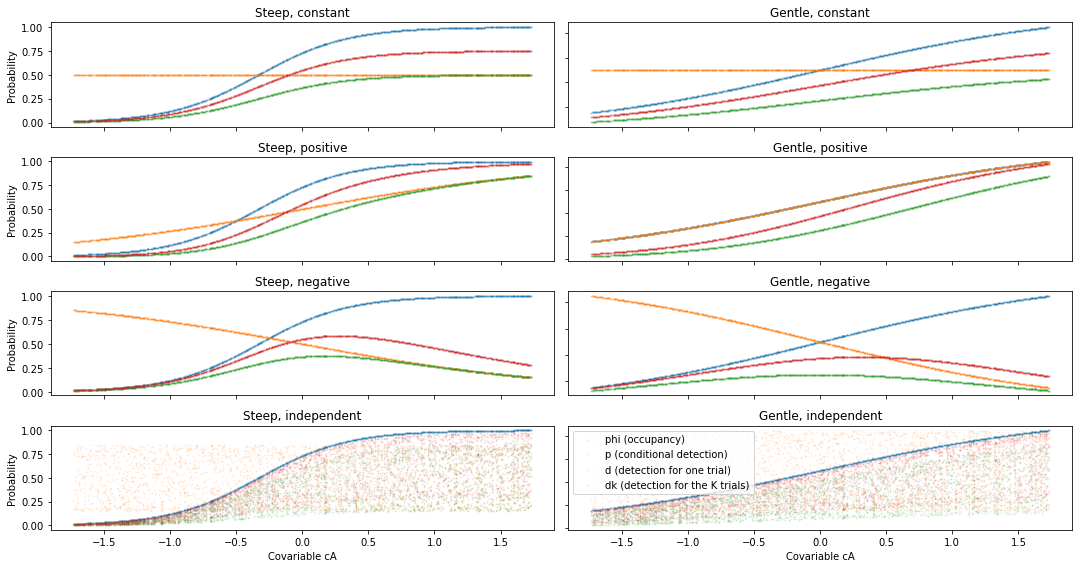

In [3]:
plt.rcParams['figure.figsize'] = (15, 8)
fig, axs = plt.subplots(4, 2)
for i in range(4):
    for j in range(2):
        axs[i, j].scatter(cA_train, psis[j, i], s=1, label="phi (occupancy)", alpha=0.1)
        axs[i, j].scatter(cA_train, ps[j, i], s=1, label="p (conditional detection)", alpha=0.1)
        axs[i, j].scatter(cA_train, ds[j, i], s=1, label="d (detection for one trial)", alpha=0.1)
        axs[i, j].scatter(cA_train, dsk[j, i], s=1, label="dk (detection for the K trials)", alpha=0.1)
        axs[i, j].set_title(labels[j, i])

for ax in axs.flat:
    ax.set(xlabel='Covariable cA', ylabel='Probability')
    ax.label_outer()
    
fig.tight_layout()
plt.legend()
plt.show()

## Model fitting and prediction

In [4]:
def get_best_model(models):
    """
    Returns the model with the lowest Akaike information criterion (AIC)
    """

    aics = [model.get_aic() for model in models]
    id_ = np.argmin(aics)
    
    return id_, models[id_]

In [5]:
lr_models = [[], []]
em_models = [[], []]
od_models = [[], []]
lr_ids = [[], []]
em_ids = [[], []]
od_ids = [[], []]

train_data_list1 = [[cA_train], (cA_train, cA_train ** 2)]
train_data_list2 = [(cA_train, cB_train),
                  (cA_train, cB_train, cA_train ** 2, cB_train ** 2),
                  (cA_train, cB_train, cA_train ** 2, cB_train ** 2, cA_train * cB_train)]

for i in range(2):
    for j in range(4):
        occupancy_label = occupancy_labels[i, j]
        binary_detection_train = binary_detections_train[i, j]
        number_detection_train = number_detections_train[i, j]
        
        if j < 3:
            train_data_list = train_data_list1
        else:
            train_data_list = train_data_list2

        lr_family = []
        em_family = []
        od_family = []
        
        for train_data in train_data_list:
            print(i, j)
            
            # Linear regression
            lr_model = Linear_Regression_Model()
            lr_model.fit(train_data, binary_detection_train)
            lr_family.append(lr_model)
            
            # Empirical model
            em_model = Empirical_Model()
            em_model.fit(train_data, binary_detection_train)
            em_family.append(em_model)
            
            #Occupancy-detection model
            od_model = Occupancy_Detection_Model(train_data, number_detection_train, K=K)
            od_model.fit()
            od_family.append(od_model)
        
        lr_ids[i].append(get_best_model(lr_family)[0])
        lr_models[i].append(get_best_model(lr_family)[1])
        
        em_ids[i].append(0)
        em_models[i].append(em_family[0])
        
        od_ids[i].append(get_best_model(od_family)[0])
        od_models[i].append(get_best_model(od_family)[1])

0 0
Optimization terminated successfully.
         Current function value: 0.844301
         Iterations: 198
         Function evaluations: 339
0 0


C:\miniconda\Lib\site-packages\statsmodels\base\model.py:2748: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
C:\miniconda\Lib\site-packages\statsmodels\base\model.py:2752: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")


Optimization terminated successfully.
         Current function value: 0.841811
         Iterations: 487
         Function evaluations: 755
0 1
Optimization terminated successfully.
         Current function value: 0.730861
         Iterations: 219
         Function evaluations: 370
0 1
Optimization terminated successfully.
         Current function value: 0.737302
         Iterations: 541
         Function evaluations: 924
0 2


C:\miniconda\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 0.741421
         Iterations: 230
         Function evaluations: 370
0 2
Optimization terminated successfully.
         Current function value: 0.744140
         Iterations: 570
         Function evaluations: 956
0 3


C:\miniconda\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 0.762996
         Iterations: 336
         Function evaluations: 519
0 3
Optimization terminated successfully.
         Current function value: 0.763782
         Iterations: 1841
         Function evaluations: 2585
0 3


C:\Users\XAVIER\Documents\Stage\SDM\occupancy_detection_model.py:31: RuntimeWarning: divide by zero encountered in log
  ll_non_null = np.log(psi) + self.endog * np.log(p) + (self.K - self.endog) * np.log(1 - p)
C:\Users\XAVIER\Documents\Stage\SDM\occupancy_detection_model.py:36: RuntimeWarning: invalid value encountered in multiply
  ll  = (self.endog != 0) * ll_non_null + (self.endog == 0) * ll_null
C:\miniconda\Lib\site-packages\statsmodels\base\optimizer.py:737: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
C:\miniconda\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\miniconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Li

1 0
Optimization terminated successfully.
         Current function value: 0.739276
         Iterations: 235
         Function evaluations: 397
1 0
Optimization terminated successfully.
         Current function value: 0.738470
         Iterations: 540
         Function evaluations: 831
1 1
Optimization terminated successfully.
         Current function value: 0.740495
         Iterations: 200
         Function evaluations: 345
1 1
Optimization terminated successfully.
         Current function value: 0.740130
         Iterations: 527
         Function evaluations: 816
1 2
Optimization terminated successfully.
         Current function value: 0.611789
         Iterations: 139
         Function evaluations: 246
1 2


C:\miniconda\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 0.602666
         Iterations: 880
         Function evaluations: 1341
1 3
Optimization terminated successfully.
         Current function value: 0.716442
         Iterations: 571
         Function evaluations: 872
1 3
Optimization terminated successfully.
         Current function value: 0.723152
         Iterations: 1698
         Function evaluations: 2414
1 3
Optimization terminated successfully.
         Current function value: 0.717710
         Iterations: 1908
         Function evaluations: 2632


## Results in the environmental space

For the 'steep, independent' scenario, that is: the probability of occupancy depends on cA and the conditional probability of detection depends on cB.

RMSE random model, occupancy:  0.3952997178699112
RMSE OD model, occupancy:  0.0692202472242282
RMSE OD model, detection:  0.2106379794534284
RMSE LR model, occupancy:  0.2942714035854278
RMSE LR model, detection:  0.12476955864385371
RMSE EM model, occupancy:  0.6536856165705072
RMSE EM model, detection:  0.4867321131990172


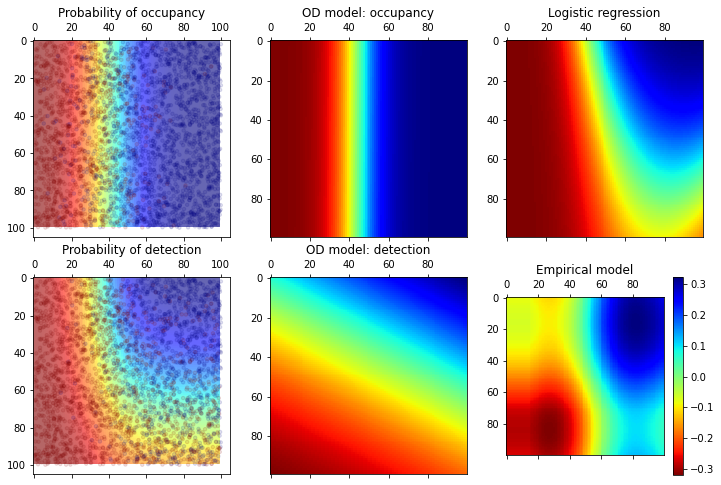

In [11]:
cA_test, cB_test = np.linspace(-np.sqrt(3), np.sqrt(3), 100), np.linspace(-np.sqrt(3), np.sqrt(3), 100)
cB_test = np.flip(cB_test)
cA_grid, cB_grid = np.meshgrid(cA_test, cB_test)
cA_test, cB_test = np.ravel(cA_grid), np.ravel(cB_grid)
test_data_list2 = [(cA_test, cB_test),
                  (cA_test, cB_test, cA_test ** 2, cB_test ** 2),
                  (cA_test, cB_test, cA_test ** 2, cB_test ** 2, cA_test * cB_test)]

od_model = od_models[0][3]
lr_model = lr_models[0][3]
em_model = em_models[0][3]

plt.rcParams['figure.figsize'] = (12, 8)
fig, axs = plt.subplots(2, 3)

phi_grid = expit(1 + 3 * cA_grid)
axs[0, 0].matshow(phi_grid, cmap='jet_r', alpha=0.6)
axs[0, 0].scatter(50 * (cA_train / np.sqrt(3) + 1), 50 * (-cB_train / np.sqrt(3) + 1),
                  cmap='jet_r', c=occupancy_labels[0, 3], alpha=1 / np.log(n_train), s=12)
axs[0, 0].set_title('Probability of occupancy')

p_grid = expit(cB_grid)
d_grid = p_grid * phi_grid
dk_grid = 1 - (1 - d_grid) ** K
axs[1, 0].matshow(dk_grid, cmap='jet_r', alpha=0.6)
axs[1, 0].scatter(50 * (cA_train / np.sqrt(3) + 1), 50 * (-cB_train / np.sqrt(3) + 1),
                  cmap='jet_r', c=binary_detections_train[0, 3], alpha=1 / np.log(n_train), s=12)
axs[1, 0].set_title('Probability of detection')

od_occupancy, od_detection = od_model.predict(test_data_list2[od_ids[0][3]])
od_occupancy, od_detection = od_occupancy.reshape(cA_grid.shape), od_detection.reshape(cA_grid.shape)
print('RMSE random model, occupancy: ', Statistics.rmse(phi_grid, 0.5))
print('RMSE OD model, occupancy: ', Statistics.rmse(phi_grid, od_occupancy))
print('RMSE OD model, detection: ', Statistics.rmse(dk_grid, od_detection))
axs[0, 1].matshow(od_occupancy, cmap='jet_r')
axs[0, 1].set_title('OD model: occupancy')
axs[1, 1].matshow(od_detection, cmap='jet_r')
axs[1, 1].set_title('OD model: detection')

lr_prediction = lr_model.predict(test_data_list2[lr_ids[0][3]])
lr_prediction = lr_prediction.reshape(cA_grid.shape)
print('RMSE LR model, occupancy: ', Statistics.rmse(phi_grid, lr_prediction))
print('RMSE LR model, detection: ', Statistics.rmse(dk_grid, lr_prediction))
axs[0, 2].matshow(lr_prediction, cmap='jet_r')
axs[0, 2].set_title('Logistic regression')

em_prediction = em_model.predict(test_data_list2[em_ids[0][3]])
em_prediction = em_prediction.reshape(cA_grid.shape)
print('RMSE EM model, occupancy: ', Statistics.rmse(phi_grid, em_prediction))
print('RMSE EM model, detection: ', Statistics.rmse(dk_grid, em_prediction))
ax = axs[1, 2].matshow(em_prediction, cmap='jet_r')
plt.colorbar(ax)
axs[1, 2].set_title("Empirical model")

plt.show()

Discussion: the logistic regression fails to disentangle the crossed effect of occupancy (correlated with cA) and detection (correlated with cB).

In [8]:
"""
x = ([0, 0, 1, 1, 1.5, 2, 2.5, 3, 2.5, 3], [10, 11, 10, 11.5, 10.5, 10, 10, 10.5, 11, 11])
y = np.array([0, 0, 0, 0, 1, 1, 1, 2, 2, 2])
x_test = ([0, 2, 3], [10, 10, 10])
a, b = np.linspace(0, 3, 100), np.linspace(10, 11.5, 100)
a, b = np.meshgrid(a, b)
a, b = np.ravel(a), np.ravel(b)
x_test = (a, b)

plt.scatter(x[0], x[1], c=y)

model = Occupancy_Detection_Model(x, y, K=2)
model.fit()
occupancy, detection = model.predict(x_test)
plt.scatter(x_test[0], x_test[1], alpha=0.1, c=detection)
plt.show()
"""

'\nx = ([0, 0, 1, 1, 1.5, 2, 2.5, 3, 2.5, 3], [10, 11, 10, 11.5, 10.5, 10, 10, 10.5, 11, 11])\ny = np.array([0, 0, 0, 0, 1, 1, 1, 2, 2, 2])\nx_test = ([0, 2, 3], [10, 10, 10])\na, b = np.linspace(0, 3, 100), np.linspace(10, 11.5, 100)\na, b = np.meshgrid(a, b)\na, b = np.ravel(a), np.ravel(b)\nx_test = (a, b)\n\nplt.scatter(x[0], x[1], c=y)\n\nmodel = Occupancy_Detection_Model(x, y, K=2)\nmodel.fit()\noccupancy, detection = model.predict(x_test)\nplt.scatter(x_test[0], x_test[1], alpha=0.1, c=detection)\nplt.show()\n'